### The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. First, skim read this article: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution [2 Marks] <br> 
### - Start with a 400x400 image (ground truth high resolution).<br> - Resize it to a 200x200 image (input image) <br> - Use RFF + Linear regression to increase the resolution to 400x400 (predicted high resolution image) <br>- Compute the following metrics: <br> $\quad$ - RMSE on predicted v/s ground truth high resolution image <br> $\quad$ - Peak SNR

Importing Libraries

In [1]:
import torch
import torchvision
import torchviz
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

Helper Functions

In [14]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [2]:
# create RFF features
def create_rff_features(X, num_features, gamma, random_state):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=gamma, random_state=random_state) # gamma  = 1/(2 * sigma**2)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)

    # X_rff = np.zeros((len(X), 2*NUM_features + 1))
    # X_rff[:, 0] = X[:, 0]
    # for i in range(NUM_features):
    #     b = np.random.randn()
    #     X_rff[:, i+1] = np.sin(2*np.pi*gamma*b*X[:, 0])
    #     X_rff[:, i + NUM_features+1] = np.cos(2*np.pi*gamma*b*X[:, 0])
    
    # # Normalize each column
    # X_rff = StandardScaler().fit_transform(X_rff)
    # return X_rff
    

    return torch.tensor(X, dtype=torch.float32).to(device)

In [3]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [4]:
def plot_reconstructed_and_original_image(original_img, net, X, title="", scale=1):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples* scale**2, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height*scale, width*scale, num_channels)

    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

Get the image

In [5]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [6]:
# Read in a image from torchvision
img = torchvision.io.read_image('dog.jpg')
print(img.shape)

torch.Size([3, 1365, 2048])


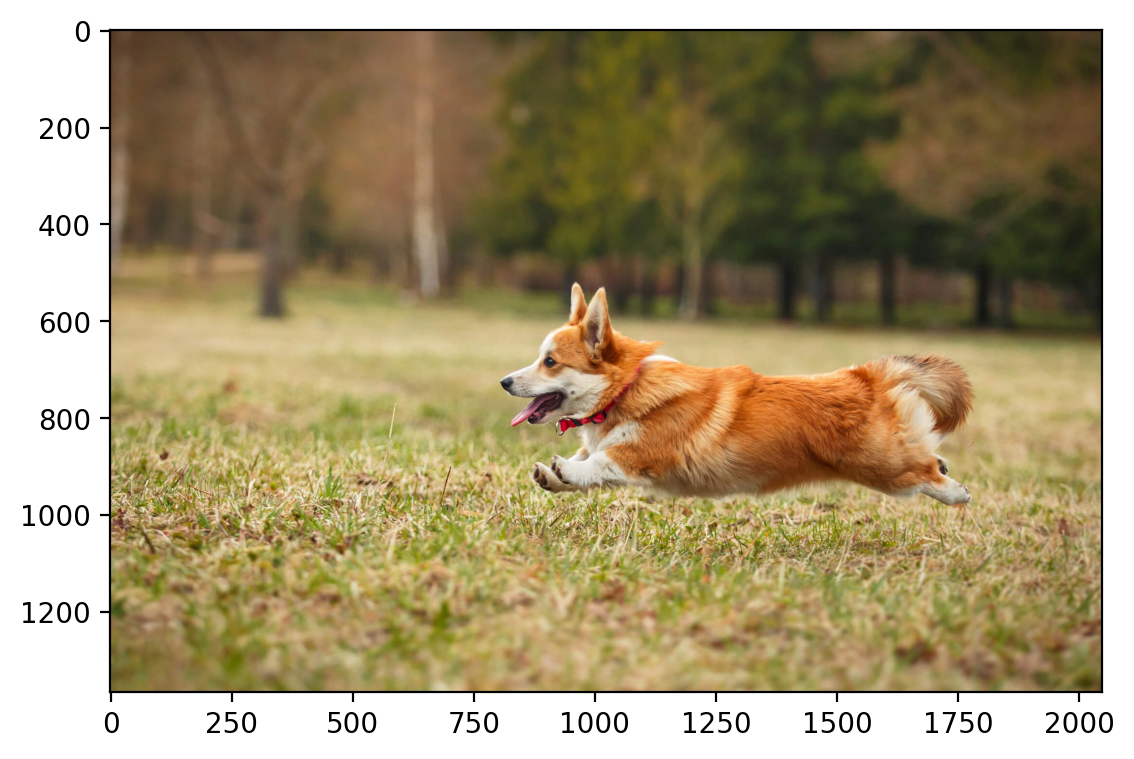

In [8]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.show()

Processing the image

In [9]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled.shape, img_scaled

(torch.Size([3, 1365, 2048]),
 tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          ...,
          [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
          [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
          [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],
 
         [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          ...,
          [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
          [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
          [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],
 
         [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
          [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
          

400 x 400 Original Image

torch.Size([3, 400, 400])


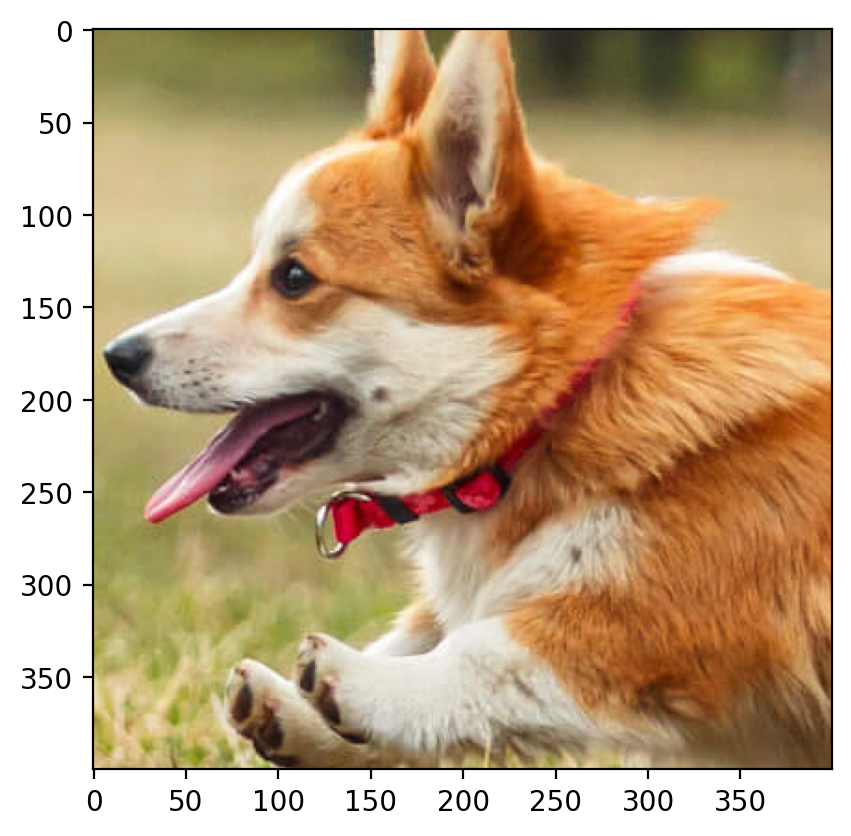

In [10]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 550, 800, 400, 400)
crop = crop.to(device)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
plt.show()

Resizing to 200 x 200 image

torch.Size([3, 200, 200])


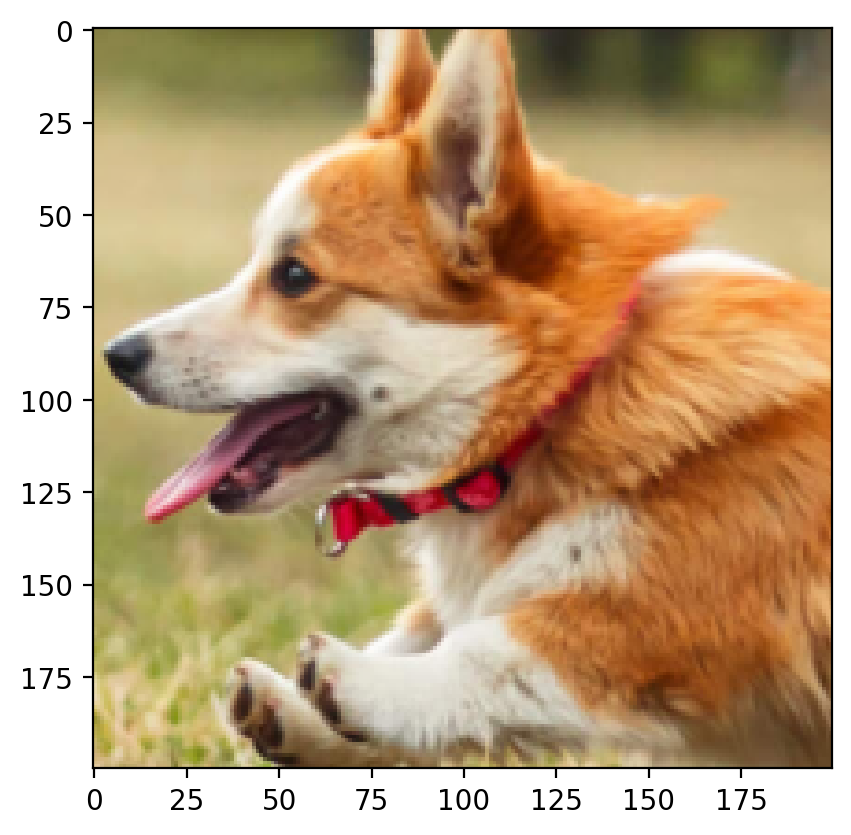

In [11]:
trans = torchvision.transforms.transforms.Resize((200,200))
resized_image = trans(crop) 
resized_image = resized_image.to(device)
print(resized_image.shape)
plt.imshow(rearrange(resized_image, 'c h w -> h w c').cpu().numpy())
plt.show()

Comparison

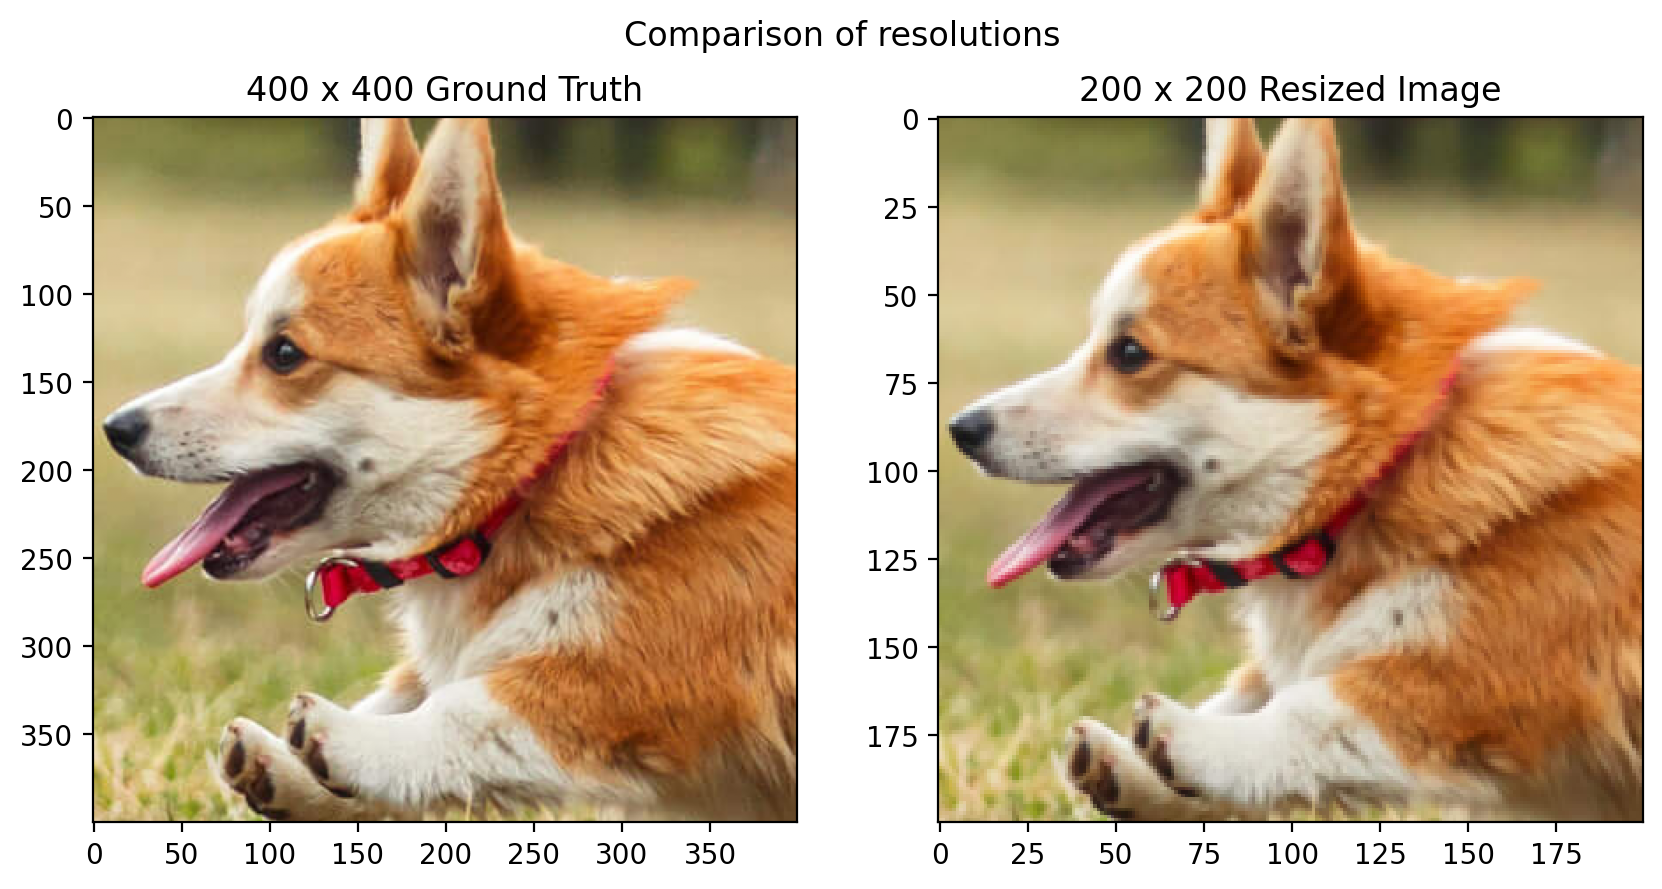

In [12]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
fig.suptitle('Comparison of resolutions')
ax[0].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
ax[0].set_title('400 x 400 Ground Truth')
ax[1].set_title('200 x 200 Resized Image')
ax[1].imshow(rearrange(resized_image, 'c h w -> h w c').cpu().numpy())
fig.subplots_adjust(top=1.1)
plt.show()

Training a neural network on 200 x 200 resized image to finally get 400 X 400 super-resolved image

Creating a coordinate map (200 x 200)

In [15]:
scale = 1
dog_X, dog_Y = create_coordinate_map(resized_image, scale=scale)
dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [16]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu()) # MinMaxScaler on dog_X from -1 to 1
dog_X_scaled = scaler_X.transform(dog_X.cpu()) # Scale the coordinates
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()
dog_X_scaled.shape, dog_X_scaled[:10, :] # First 10 entries of dog_X scaled by MinMaxScaler from -1 to 1

(torch.Size([40000, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9899],
         [-1.0000, -0.9799],
         [-1.0000, -0.9698],
         [-1.0000, -0.9598],
         [-1.0000, -0.9497],
         [-1.0000, -0.9397],
         [-1.0000, -0.9296],
         [-1.0000, -0.9196],
         [-1.0000, -0.9095]]))

Defining the model class<br> Model used: _Fully Connected Neural Network_

In [17]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features): # Neural Network has "in_features" number of input features and "out_features" number of output features.   
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

!['NN.png'](NN.png)

Generating Random Fourier Features

In [48]:
X_rff = create_rff_features(dog_X_scaled, 12000, 25, random_state = 42) # num_of_features = 37500, gamma = 0.008

In [49]:
X_rff, X_rff.shape

(tensor([[ 0.0090, -0.0091, -0.0129,  ...,  0.0123, -0.0129,  0.0124],
         [ 0.0082, -0.0078, -0.0129,  ...,  0.0123, -0.0129,  0.0123],
         [ 0.0074, -0.0064, -0.0129,  ...,  0.0122, -0.0129,  0.0121],
         ...,
         [ 0.0084,  0.0092,  0.0020,  ..., -0.0105, -0.0011,  0.0098],
         [ 0.0092,  0.0079,  0.0023,  ..., -0.0106, -0.0009,  0.0094],
         [ 0.0099,  0.0065,  0.0026,  ..., -0.0108, -0.0007,  0.0091]]),
 torch.Size([40000, 12000]))

Training

In [50]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=12000, out_features=3, bias=True)
)

In [51]:
train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.343595
Epoch 100 loss: 0.007676
Epoch 200 loss: 0.007221
Epoch 300 loss: 0.007075
Epoch 400 loss: 0.007001
Epoch 500 loss: 0.006956
Epoch 600 loss: 0.006927
Epoch 700 loss: 0.006905
Epoch 800 loss: 0.006886
Epoch 900 loss: 0.006870
Epoch 1000 loss: 0.006855
Epoch 1100 loss: 0.006842
Epoch 1200 loss: 0.006829
Epoch 1300 loss: 0.006816
Epoch 1400 loss: 0.006805
Epoch 1500 loss: 0.006794
Epoch 1600 loss: 0.006783
Epoch 1700 loss: 0.006773
Epoch 1800 loss: 0.006764
Epoch 1900 loss: 0.006755
Epoch 2000 loss: 0.006746
Epoch 2100 loss: 0.006738
Epoch 2200 loss: 0.006730
Epoch 2300 loss: 0.006722
Epoch 2400 loss: 0.006715


0.006708119530230761

Resized image reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


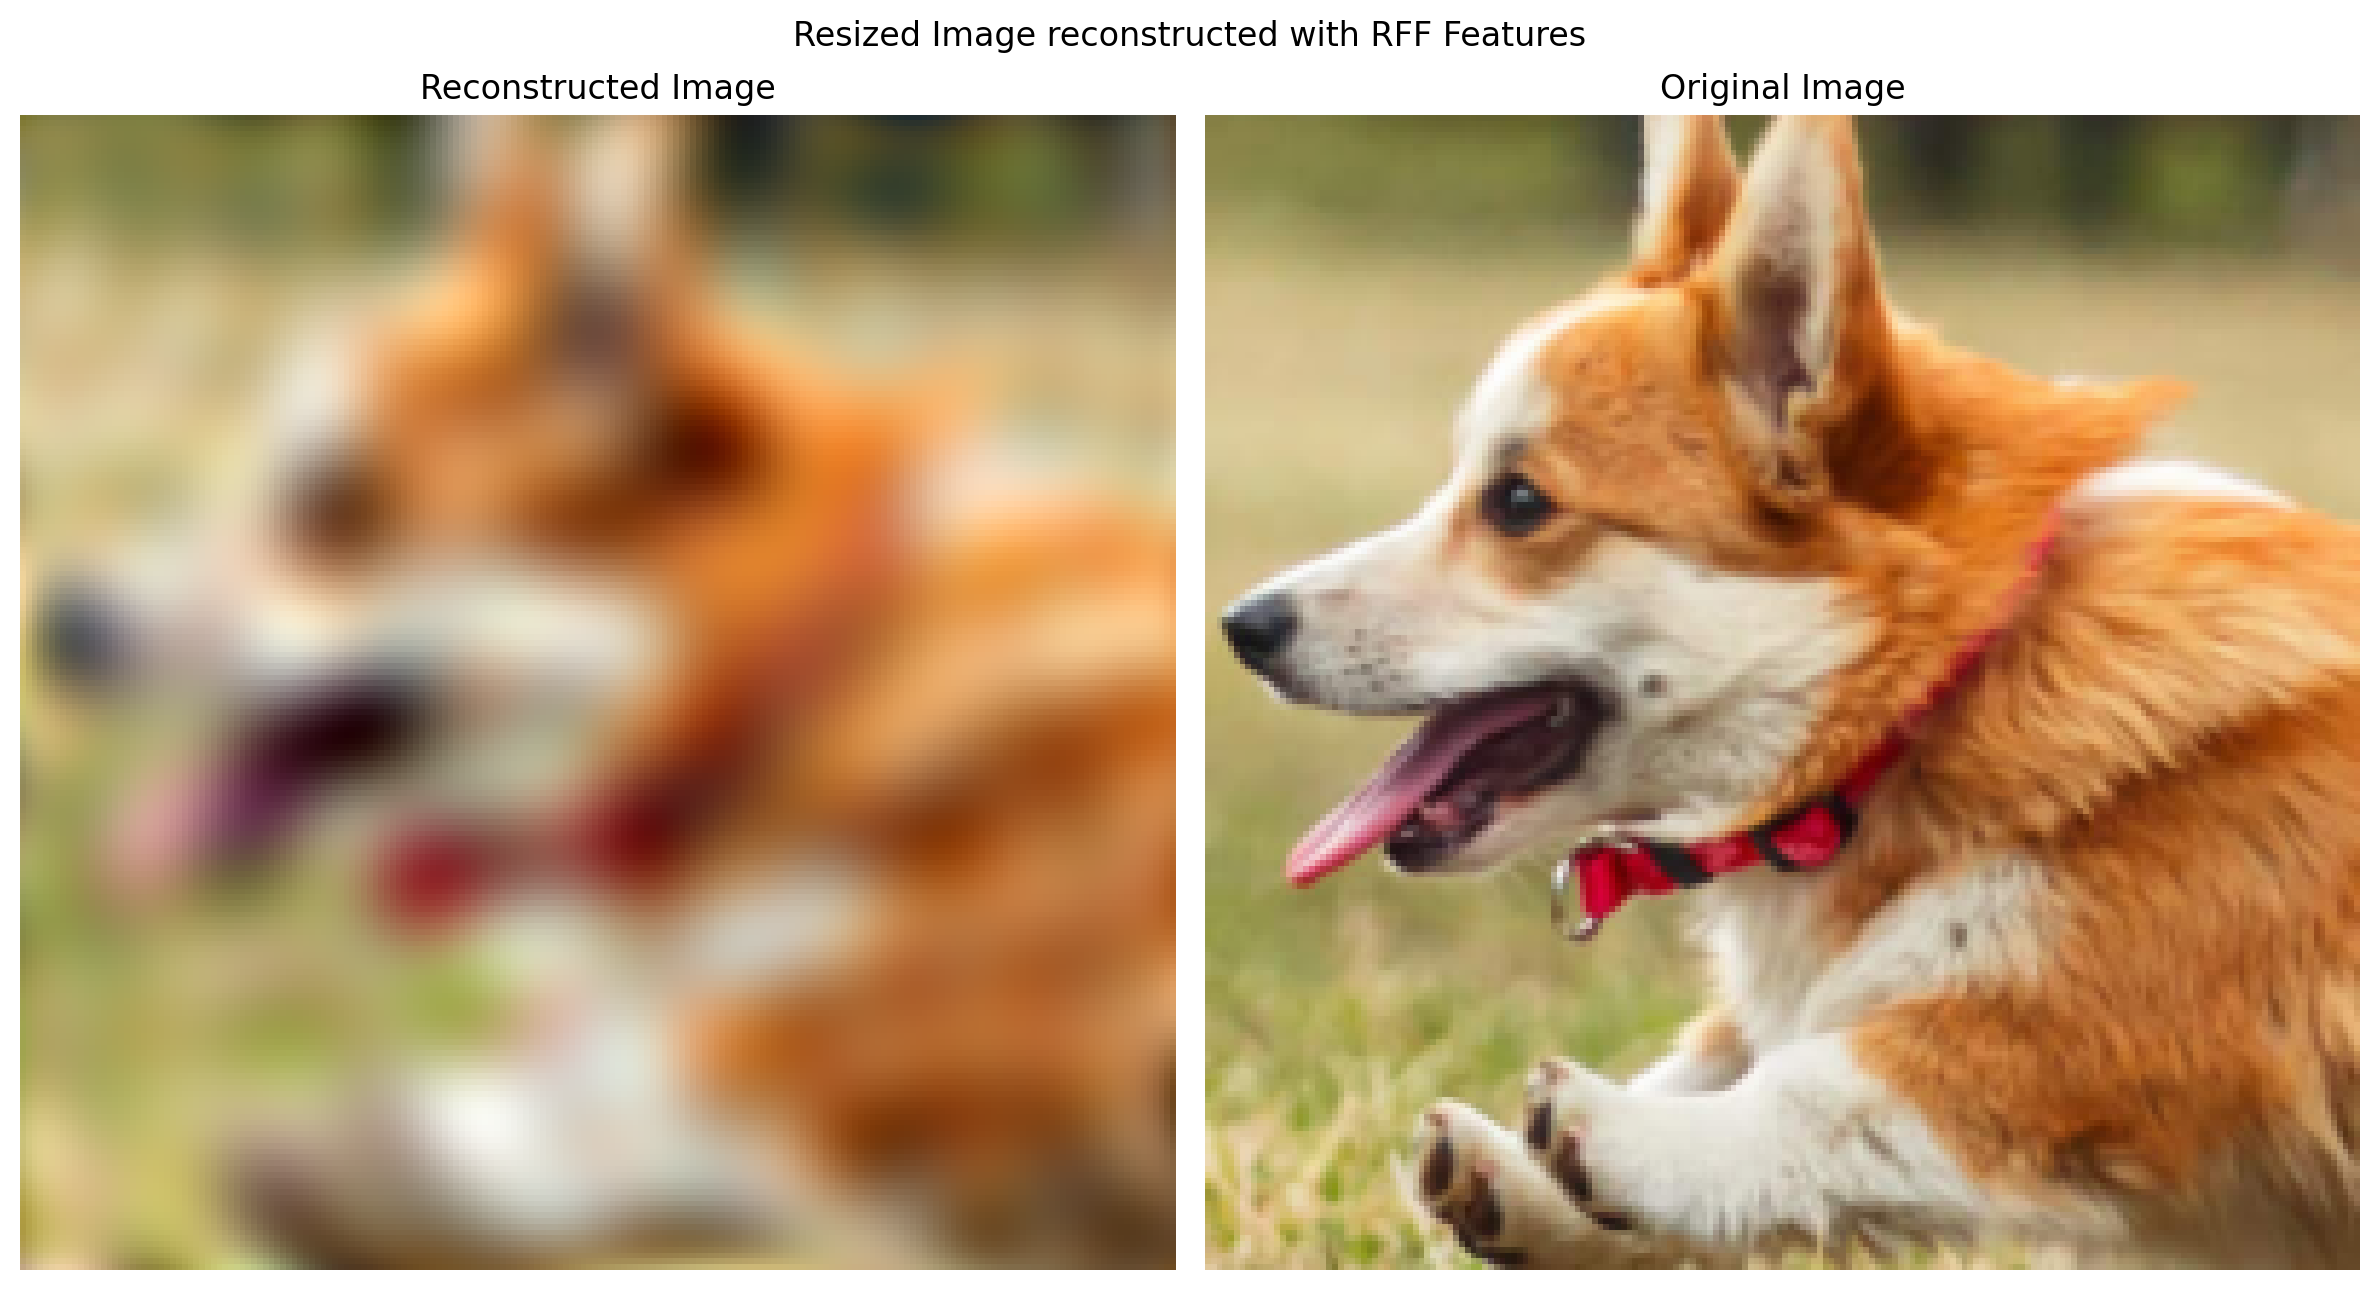

In [52]:
plot_reconstructed_and_original_image(resized_image, net, X_rff,'Resized Image reconstructed with RFF Features', scale=1)